In [1]:
from mlgrad.risk import ERisk, ERiskGB
from mlgrad.loss import SquareErrorLoss
from mlgrad.model import LinearFuncModel, SigmaNeuronModel, FFNetworkModel, \
                        FFNetworkFuncModel, SigmaNeuronModelLayer, LinearModel
from mlgrad.func import SoftPlus, Sqrt, Sigmoidal, HingeSqrt, Arctang

from mlgrad import erm_fg, erm_irgd, fg, erm_fg, erisk
from mlgrad.regr import m_regression_irls
from mlgrad.af import averaging_function
from mlgrad.weights import MWeights

import numpy as np

In [2]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt

In [3]:
X, Y = datasets.fetch_california_housing(return_X_y=True)
N = len(X)
print(X.shape, X.dtype)
print(Y.shape, Y.dtype)

(20640, 8) float64
(20640,) float64


In [4]:
# Y = Y.astype('d')
X = np.ascontiguousarray(X)
X_o = preprocessing.robust_scale(X)
Y_o = Y.copy()

In [21]:
print(X_o.flags)
print(Y_o.flags)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



In [6]:
def find_alpha(X, E, mod, W=None):
    Yh = np.array([mod(Xk) for Xk in X])
    if W is None:
        alpha = np.sum(E * Yh) / np.sum(Yh * Yh)
    else:
        alpha = np.sum(W * E * Yh) / np.sum(W * Yh * Yh)
    return alpha

In [7]:
def find_alpha_cls(X, E, mod, W=None):
    Yh = np.array([mod(Xk) for Xk in X])
    if W is None:
        alpha = np.sum(E * Yh) / np.sum(Yh * Yh)
    else:
        alpha = np.sum(W * E * Yh) / np.sum(W * Yh * Yh)
    return alpha

In [8]:
def find_param(X, E, mod, loss_func, W=None):
    rs = ERisk(X, E, mod, loss_func)
    if W is not None:
        rs.use_weights(W)
    alg_fg = erm_fg(rs, h=0.01, tol=1.0e-6)

In [9]:
def find_param_alpha_agg(X, Y, lfm, mod, loss_func, agg, n_iter=50, tol=1.0e-6):
    alpha = alpha_min = 1

    W = np.zeros(len(X), 'd')
    L = np.array([loss_func(lfm(Xk), Yk) for Xk, Yk in zip(X, Y)])
    agg.fit(L)
    # lval = lval_min = agg.u
    agg.gradient(L, W)

    param_min = mod.param.copy()

    L = np.array([loss_func(lfm(Xk) + alpha*mod(Xk), Yk) for Xk, Yk in zip(X, Y)])
    agg.fit(L)
    lval = lval_min = agg.u
    # agg.gradient(L, W)
    
    for j in range(n_iter):        
        lval_prev = lval

        E = np.array([(Yk - lfm(Xk))/alpha for Xk, Yk in zip(X,Y)])
        find_param(X, E, mod, loss_func, W)
        
        E = np.array([Yk - lfm(Xk) for Xk, Yk in zip(X,Y)])
        alpha = find_alpha(X, E, mod, W)

        if lval < lval_min:
            param_min = mod.param.copy()
            alpha_min = alpha
            lval_min = lval

        L = np.array([loss_func(lfm(Xk) + alpha*mod(Xk), Yk) for Xk, Yk in zip(X, Y)])
        agg.fit(L)
        lval = agg.u
        # agg.gradient(L, W)
        
        if lval < lval_min:
            param_min = mod.param.copy()
            alpha_min = alpha
            lval_min = lval
            
        if j < 2:
            continue
        
        if abs(lval - lval_prev) / (1 + abs(lval_min)) < tol:
            break
            
    mod.param[:] = param_min
    alpha = alpha_min
    return alpha

In [10]:
def find_param_alpha(X, Y, lfm, mod, loss_func, n_iter=50, tol=1.0e-6):
    lval = lval_min = 10000000.
    alpha_min = alpha = 1

    for j in range(n_iter):
        lval_prev = lval

        E = np.array([(Yk - lfm(Xk))/alpha for Xk, Yk in zip(X,Y)])
        find_param(X, E, mod, loss_func)
        
        E = np.array([Yk - lfm(Xk) for Xk, Yk in zip(X,Y)])
        alpha = find_alpha(X, E, mod)

        lval = np.mean([loss_func(lfm(Xk) + alpha*mod(Xk), Yk) for Xk, Yk in zip(X, Y)])

        if lval < lval_min:
            param_min = mod.param.copy()
            alpha_min = alpha
            lval_min = lval

        if j < 2:
            continue
        
        if abs(lval - lval_prev) / (1 + abs(lval_min)) < tol:
            break

    mod.param[:] = param_min
    alpha = alpha_min
    return alpha        

In [11]:
def gb_fit_agg(X, Y, alpha=0.75, n_iter=30):
    N = len(X)
    lfm = LinearFuncModel()
    agg = averaging_function('WM', alpha=alpha)
    loss_func = SquareErrorLoss()
    lvals = []
    a = 1
    for k in range(n_iter):
        # body = FFNetworkModel()
        # layer = SigmaNeuronModelLayer(Sigmoidal(1.0), X.shape[1], 3)
        # body.add(layer)
        # head = LinearModel(3)
        # mod = FFNetworkFuncModel(head, body)
        # mod.allocate()
        mod = SigmaNeuronModel(Sigmoidal(1.0), X.shape[1])
        mod.init_param()

        a = find_param_alpha_agg(X, Y, lfm, mod, loss_func, agg)
        # print(k, lfm.weights)
        lfm.add(mod, a)

        L = np.array([loss_func(lfm(Xk), Yk) for Xk, Yk in zip(X,Y)])
        agg.fit(L)
        lvals.append(agg.u)
    return lfm, lvals

In [12]:
def gb_fit(X, Y, n_iter=100):
    lfm = LinearFuncModel()
    loss_func = SquareErrorLoss()
    lvals = []
    for k in range(n_iter):
        # body = FFNetworkModel()
        # layer = SigmaNeuronModelLayer(Sigmoidal(1.0), X.shape[1], 3)
        # body.add(layer)
        # head = LinearModel(3)
        # mod = FFNetworkFuncModel(head, body)
        # mod.allocate()
        mod = SigmaNeuronModel(Sigmoidal(1.0), X.shape[1])
        mod.init_param()

        a = find_param_alpha(X, Y, lfm, mod, loss_func)
        lfm.add(mod, a)

        lvals.append(np.mean([loss_func(lfm(Xk), Yk) for Xk, Yk in zip(X,Y)]))
    return lfm, lvals

In [29]:
lfm, lvals = gb_fit(X_o, Y_o, n_iter=50)
# print(np.asarray(lfm.weights))

In [44]:
alpha=0.7
lfm_agg, lvals_agg = gb_fit_agg(X_o, Y_o, alpha=alpha, n_iter=50)
# print(np.asarray(lfm_agg.weights))

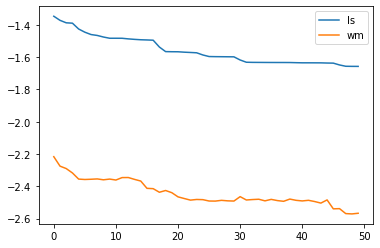

In [45]:
plt.plot(np.log(lvals), label='ls')
plt.plot(np.log(lvals_agg), label='wm')
plt.legend()
plt.show()

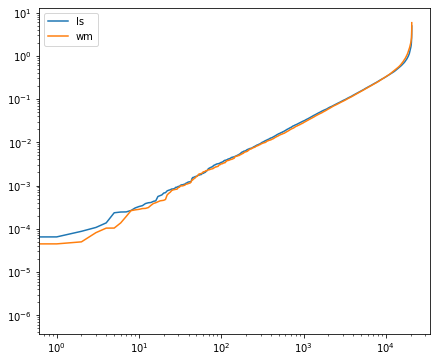

In [46]:
plt.figure(figsize=(7,6))
plt.loglog(sorted([abs(lfm(X_o[k])-Y_o[k]) for k in range(N)]), label='ls')
plt.loglog(sorted([abs(lfm_agg(X_o[k])-Y_o[k]) for k in range(N)]), label='wm')
plt.legend()
plt.show()

In [47]:
Y_ls = np.array([lfm(Xk) for Xk in X_o])
Y_agg = np.array([lfm_agg(Xk) for Xk in X_o])

In [48]:
acc_ls = metrics.mean_absolute_error(Y_o, Y_ls)
acc_wm = metrics.mean_absolute_error(Y_o, Y_agg)
print(acc_ls, acc_wm)

0.4490139777317723 0.5099830997005957


In [49]:
acc_ls = metrics.median_absolute_error(Y_o, Y_ls)
acc_wm = metrics.median_absolute_error(Y_o, Y_agg)
print(acc_ls, acc_wm)

0.3380937235964263 0.34110484887159886


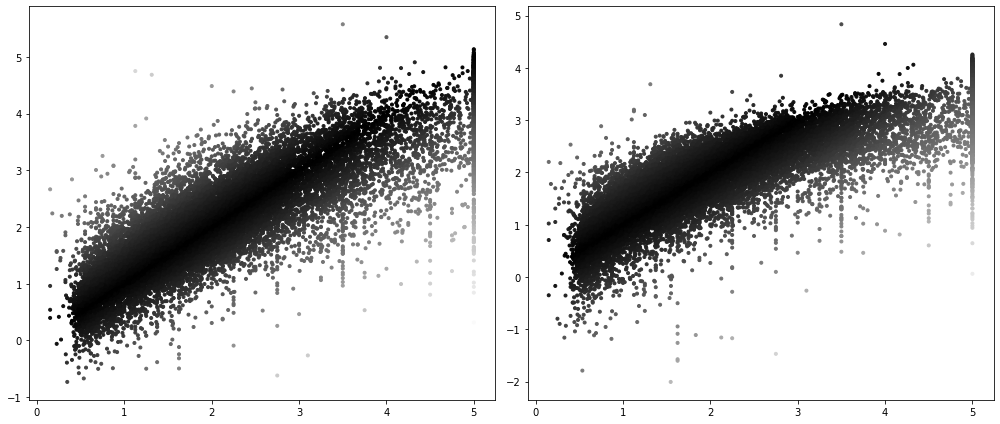

In [50]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(Y_o, Y_ls, c=np.abs(Y_o-Y_ls), s=9, cmap=plt.cm.Greys_r)
plt.subplot(1,2,2)
plt.scatter(Y_o, Y_agg, c=np.abs(Y_o-Y_agg), s=9, cmap=plt.cm.Greys_r)
plt.tight_layout()
plt.show()